https://earthexplorer.usgs.gov/ - 로그인하고 설정해서 다운받자

https://foss4g.tistory.com/563 - Landsat 8호 위성영상에서 밝기온도 계산하기 (2)

https://ekscc.re.kr/xml/31727/31727.pdf -  정규화식생지수?

https://datasvc.nmsc.kma.go.kr/resources/common/pdf/NMSC-SCI-ATBD-LST_v1.0.pdf - 분리대기창

https://blog.si-analytics.ai/57 - 이거 좀 봐야할듯

http://kpaj.or.kr/_common/do.php?a=full&bidx=640&aidx=8474 - 열섬관련 논문

Landsat 8 위성자료를 이용한 지표면온도 산출 및 도심녹지효과 분석 - 검색 논문봐

http://kpaj.or.kr/xml/04911/04911.pdf - 정규화 지수로 도시열섬 취약지역 분석하는 논문

https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO201614652759836&oCn=JAKO201614652759836&dbt=JAKO&journal=NJOU00291574 - 흠 이건 논문

https://koreascience.kr/article/JAKO201931765018212.page - 이건 구름탐지 및 복원 논문

https://foss4g.tistory.com/1583 - 이거는 MODIS 위성영상 다운인데 해결못하고 있으니 참고..?

https://medium.com/nerd-for-tech/atmospheric-correction-of-satellite-images-using-python-42128504afc3 - 이거 한번 참고해보기

https://github.com/sdtaylor/unpackqa - unpackqa 깃허브 참고

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium import FeatureGroup
from config import vworld_key
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from shapely import wkt
import rasterio
import base64
from matplotlib import pyplot
from rasterio.plot import show
import matplotlib.pyplot as plt
from tqdm import tqdm

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

---

## 지표온도(Land surface temperature, LST) 계산과정

### 1. 영상 DN(Digidal Number) 값을 대기상부 복사휘도TOA Radiance(대기상부 복사휘도)로 변환

Landsat 8 = OLI(Operational Land Imager sensor) 센서의 9개 BAND + TIRS(Thermal Infrared Sensor) 센서의 2개 BAND(10&11) = 총 11개의 BAND

Thermal Band(10&11)는 대기(CO2)에 영향을 받는데, BAND 11은 BAND 10보다 대기에 대한 영향을 많이 받아 온도가 다소 낮게 측정되는 경우가 있음 <br/>따라서 본 분석에서는 BAND 10을 활용할 것임._([Yale, 2016]([label](https://www.researchgate.net/file.PostFileLoader.html?id%3D553172cbf079ed23728b4596%26assetKey%3DAS%3A273759607427072%401442280784589)))_

Landsat 8 위성자료는 밴드별로 정량화된 값(Q<sub>cal</sub> : Digital Number)으로 제공되기 때문에 위성의 밴드특성을 이용하여 복사에너지로 변환할 수 있음.(USGS)<br>
아래의 선형회귀식의 상수를 이용하여 계산함._([USGS, 2015](https://www.greenpolicy360.net/mw/images/Landsat8DataUsersHandbook.pdf))_

TOA 분광 복사휘도(Top Of Atmosphere spectral radiance) = <br>밴드 고유의 배수 환산계수(Band-specific multiplicative rescaling factor) * DN 값 + 밴드 고유의 가산 환산계수(Band-specific additive rescaling factor)

<img src="./pic/TSR.png" width="400" height="150"><br>TOA 분광 복사휘도의 단위 -> W / (m<sup>2</sup> * sr * μm)

### 2. TOA 분광 복사휘도를 위성사진의 밝기온도(At-satellite brightness temperature)로 재계산

K1,K2 = 밴드 고유의 열 변환 상수(Band-specific thermal conversion constant)<br>위성사진의 밝기온도(At-satellite bright temperature) = K2 / ln( K1 / TOA 분광 복사휘도 + 1)

<img src="./pic/ASBT.png" width="400" height="150"><br>계산된 밝기온도의 단위는 절대온도(Kelvin, K)

배수 환산계수와 가산 환산계수는 각각 RADIANCE_MULT_BAND_{NUMBER}, RADIANCE_ADD_BAND_{NUMBER} 형식, <br>열 변환 상수 K1과 K2는 각각 K1_CONSTANT_BAND_{NUMBER}, K2_CONSTANT_BAND_{NUMBER}형식으로 메타데이터 내에 정의되어 있음

### 3. NDVI(Normalized Difference Vegetation Index)를 통해 지표면 방출률 계산

방출률은 시간에 따라 조금씩 또는 급격하게 변화하는 특성이 있기 때문에,<br>실시간 위성 관측 자료를 바탕으로 직접 계산된 방출률을 사용하여 지표면 온도를 산출하는 것이 적합하다 판단됨.

위성 자료를 이용한 방출률의 계산은 NDVI(Normalized Difference Vegetation Index)를 활용하여 방출률과 Mapping하였음. (NDVI = 정규식생지수)<br>NDVI는 가시광선과 근적외선에서 녹색 식물의 반사율 차이가 크게 나는 특성을 이용하여, 위성사진에서 해당지역의 식생 분포를 정량적으로 파악할 수 있음.

NDVI는 Landsat 8 영상의 BAND4(RED)와 BAND5(NIR)를 이용해 산출함.<br>BAND4 - 엽록소 흡수량을 측정하여 식물종을 구분<br>BAND5 - 식생 유형과 수륙의 경계를 식별하고 토양 구분

NDVI = (BAND5 - BAND4) / (BAND5 + BAND4) [_(Eo Seonghee et al., 2021)_](https://ekscc.re.kr/xml/31727/31727.pdf)

<img src="./pic/NDVI.PNG" width="400" height="150">

<br><img src="./pic/Emissivity.PNG" width="800" height="300"><br>표 - NDVI 범위에 따른 방출률.[_(Zhang et al., 2006)_](https://www.researchgate.net/publication/222255366_A_C_program_for_retrieving_land_surface_temperature_from_the_data_of_Landsat_TMETM_band6)

### 4. 밝기온도값(1&2)과 지표면 방출률(3)을 이용하여 지표면온도 계산

지표면온도 = $지표면방출률^\frac{1}{4}$ * 밝기온도

<img src="./pic/LST.png" width="400" height="150"><br>계산된 밝기온도의 단위는 절대온도(Kelvin, K)

배수 환산계수와 가산 환산계수는 각각 RADIANCE_MULT_BAND_{NUMBER}, RADIANCE_ADD_BAND_{NUMBER} 형식, <br>열 변환 상수 K1과 K2는 각각 K1_CONSTANT_BAND_{NUMBER}, K2_CONSTANT_BAND_{NUMBER}형식으로 메타데이터 내에 정의되어 있음

---

## 기존 Landsat 8 이미지를 활용하지 않고 새로운 이미지를 활용한 이유

1. 밝기온도 계산시, 계절과 맞지 않다고 판단되는 array값이 나옴.

2. 기존 Landsat 8 이미지의 metadata 좌표를 지도에 mapping 하여 비교했을 때, Geometric Correction(기하 보정)이 되어있지 않은 것으로 파악됨.

3. 이미지 촬영 시점의 운량이 높아 열섬화 파악 및 분석이 어려움

### ‘21년~‘22년 6월~9월 기간의 안산시를 포함하는, 새로운 Landsat 8 데이터를 다운받아 mapping하였음.
|2021|2022|
|:---:|:---:|
|LC08_L2SP_116034_20210602_20210608_02_T1|LC08_L2SP_116034_20220621_20220701_02_T1|
|LC08_L2SP_116034_20210720_20210729_02_T1|LC09_L2SP_116034_20220816_20230402_02_T1(landsat9)|
|LC08_L2SP_116034_20210805_20210811_02_T1|LC08_L2SP_116034_20220909_20220914_02_T1|
|LC08_L2SP_116034_20210922_20210930_02_T1|LC08_L2SP_116034_20220925_20221004_02_T1|

### 새로운 Landsat 8 데이터는 지도에 정확히 mapping되며, 운량도 적은 편으로 열섬화 파악이 상대적으로 원활함.

---

### 활용함수 정의

In [311]:
# TOA 분광 복사휘도 (TOA Spectral Radiance) 계산함수 정의
def cal_TSR(data, RMULT, RADD):
    TSR = RMULT * data.astype(np.float32) + RADD
    return TSR

# 밝기온도(At-Satellite Bright Temperature) 계산함수 정의
def cal_kelvin(data, K1, K2):
    ASBT = K2 / np.log((K1 / data) + 1)
    return ASBT

# NDVI 범위에 따른 방출률(ε) 계산함수 정의
def cal_emissivity(band4, band5):
    epsilon = 1E-7 # 0 / 0 상황을 피하기 위해 epsilon(계산에 영향을 주지 않는 크기의 수) 추가

    # NDVI 범위에 따른 방출률 표를 기반으로 threshold 정의
    threshold1 = 0.727
    threshold2 = 0.157
    threshold3 = -0.18

    # NDVI 계산
    ndvi = (band5 - band4) / (band5 + band4 + epsilon)
    ndvi[ndvi == 0] = 0.0001 # np.log에 0이 들어가는 상황을 피하기 위해 계산에 영향을 주지 않는 크기의 수로 대체
    
    # NDVI 범위에 따른 방출률 Mapping (NDVI to emissivity)
    ndvi = np.where(ndvi > threshold1, 0.99, ndvi)
    ndvi = np.where((ndvi >= threshold2) & (ndvi <= threshold1), 1.0094 + (0.047 * np.log(ndvi)), ndvi)
    ndvi = np.where((ndvi >= threshold3) & (ndvi < threshold2), 0.97, ndvi)
    ndvi = np.where(ndvi < threshold3, 0.95, ndvi)

    return ndvi # emissivity로 매핑된 array 출력

# NDVI 범위에 따른 방출률(ε) 계산함수 정의
def cal_LST(ASBT, emissivity):
    LST = emissivity ** (1/4) * ASBT
    return LST

---

In [312]:
# Metadata file(xml형식)에서 필요 데이터만 뽑아 데이터프레임 생성
xml_dic = {
    'image_id':[],
    'time':[],
    'coordinates':[],
    'tem_array':[],
}

# 상위 디렉토리 경로 설정
base_directory = "dataset/Landsat8"  # 디렉토리 경로 설정

# 상위 디렉토리 내의 모든 하위 디렉토리 가져오기
subdirectories = [os.path.join(base_directory, d) for d in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, d))]

# 각 서브 디렉토리를 반복하면서 XML 파일 읽기
for directory in subdirectories:
    # 디렉토리 내의 Metadata XML 파일 탐색 (폴더 당 1개씩만 있기 때문에 인덱스 0으로 로드)
    xml_file = [f for f in os.listdir(directory) if f.endswith("MTL.xml")][0]

    # XML path define and read
    xml_file_path = os.path.join(directory, xml_file)
    with open(xml_file_path, 'r', encoding='utf-8') as f:
        xml_doc = f.read()

    # beautifulsoup으로 xml parsing 
    soup = bs(xml_doc, 'lxml')

    # 위성사진 id 저장
    xml_dic['image_id'].append(soup.find("landsat_product_id").text)

    # 위성사진 시간 저장(string을 datetime 객체로 변환)
    time = soup.find("date_acquired").text + ' ' + soup.find("scene_center_time").text.split(".")[0]
    xml_dic['time'].append(datetime.strptime(time, "%Y-%m-%d %H:%M:%S"))

    # 이미지 corner 위치정보 Polygon 객체로 저장
    coordinates = []
    corner_point = ['ll', 'lr', 'ur', 'ul']
    for corner in corner_point:
        # 위,경도 Rescaling Coefficient 정의
        lat_re, lon_re = 0.0035, 0.022
        coordinates.append([float(soup.find("corner_%s_lat_product"%corner).text), float(soup.find("corner_%s_lon_product"%corner).text)])
    xml_dic['coordinates'].append(coordinates)

    # TIF path check & file Read
    BAND4 = [f for f in os.listdir(directory) if f.endswith("B4.TIF")][0] # Visible ray band
    BAND4_path = os.path.join(directory, BAND4)
    
    BAND5 = [f for f in os.listdir(directory) if f.endswith("B5.TIF")][0]  # Near InfraRed band
    BAND5_path = os.path.join(directory, BAND5)

    BAND10 = [f for f in os.listdir(directory) if f.endswith("B10.TIF")][0] # Thermal band
    BAND10_path = os.path.join(directory, BAND10)

    # Bands data Read
    BAND4_data = rasterio.open(BAND4_path).read(1).astype(np.float32)
    BAND5_data = rasterio.open(BAND5_path).read(1).astype(np.float32)
    band10_data = rasterio.open(BAND10_path).read(1).astype(np.float32)
    
    # 배수환산계수(RADIANCE_MULT_BAND_n) 와 가산 환산계수(RADIANCE_ADD_BAND_n) 정의 및 계산 (process 1)
    rad_mul = float(soup.find("radiance_mult_band_10").text)
    rad_add = float(soup.find("radiance_add_band_10").text)

    # TOA 분광 복사휘도 계산함수
    BAND10_TSR = cal_TSR(band10_data, rad_mul, rad_add)

    #  Thermal band의 보정상수 K1 & K2 정의 및 밝기온도 계산 (process 2)
    K1_10 = float(soup.find("k1_constant_band_10").text)
    K2_10 = float(soup.find("k2_constant_band_10").text)

    # 밝기온도(At-Satellite Bright Temperature) 계산함수
    BAND10_kelvin = cal_kelvin(BAND10_TSR, K1_10, K2_10)
    
    # BAND4와 BAND5를 이용하여 NDVI계산 및 지표면방출률(3) 매핑 (process 3)
    emissivity = cal_emissivity(BAND4_data, BAND5_data)
    
    # 밝기온도와 지표면 방출률(3)을 이용하여 지표면온도 계산 (process 4)
    LST = cal_LST(BAND10_kelvin, emissivity)

    # BAND10의 지표면온도 평균 계산 후, 절대온도(K) -> 섭씨온도(C) 변환
    BAND10_celsius = LST - 273.15
    
    # 데이터 배열 K에서 0이하로 변환된 요소들을 0으로 변환
    BAND10_celsius[BAND10_celsius <= 0] = 0

    # # 남길 부분의 인덱스 범위 설정
    # row_start, row_end = 4000, 5000
    # col_start, col_end = 4000, 5000

    # # 해당 부분 이외의 모든 요소를 NaN으로 변환
    # BAND10_celsius[:row_start, :] = 0
    # BAND10_celsius[row_end:, :] = 0
    # BAND10_celsius[:, :col_start] = 0
    # BAND10_celsius[:, col_end:] = 0

    xml_dic['tem_array'].append(BAND10_celsius)

# xml_dic 데이터프레임으로 변환
xml_df = pd.DataFrame(xml_dic)
xml_df

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(
C:\Users\user\AppData\Local\Temp\ipykernel_28132\4039504268.py:26: RuntimeWarning: invalid value encountered in log
  ndvi = np.where((ndvi >= threshold2) & (ndvi <= threshold1), 1.0094 + (0.047 * np.log(ndvi)), ndvi)


In [131]:
image_array = xml_df['tem_array'].tolist()[0]

# 이미지를 반시계 방향으로 2도 회전
angle = 2  # 반시계 방향으로 2도 회전
image = Image.fromarray(image_array)
image = image.rotate(angle, expand=True, resample=Image.BICUBIC)

In [143]:
xml_df['coordinates'].tolist()[0]

[[36.36129, 125.35362],
 [36.41258, 127.97387],
 [38.56739, 127.94396],
 [38.51198, 125.2476]]

In [266]:
cor = [[36.36129, 125.35362],
 [36.41258, 127.97387],
 [38.56739, 127.94396],
 [38.51198, 125.2476]]

In [267]:
for c in cor:
    # 위,경도 Rescaling Coefficient 정의
    lat_re, lon_re = 0.0038, 0.022 # 반시계로 1도 틀었을 때는 0.0008, 0.019
    c[0] += lat_re
    c[1] += lon_re

In [268]:
cor

[[36.365089999999995, 125.37562000000001],
 [36.41638, 127.99587000000001],
 [38.57119, 127.96596000000001],
 [38.51578, 125.26960000000001]]

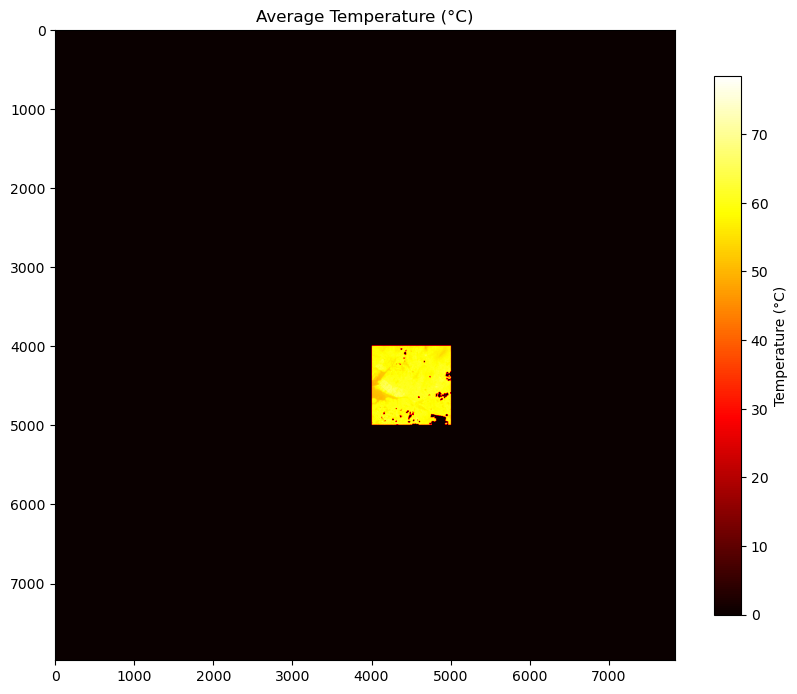

In [269]:
import folium
from rasterio.plot import show
import matplotlib.pyplot as plt
from folium import plugins
from matplotlib.colors import ListedColormap
from PIL import Image
from io import BytesIO

# Folium 맵 생성
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=10)  # 지도의 중심 좌표와 줌 레벨 설정

# 이미지를 반시계 방향으로 10도 회전
angle = 0  # 반시계 방향으로 10도 회전
image = Image.fromarray(xml_df['tem_array'].tolist()[0])
image = image.rotate(angle, expand=True, resample=Image.BICUBIC)

# 회전된 이미지를 NumPy 배열로 변환
rotated_image_array = np.array(image)

# 일반 PNG 이미지를 Folium에 추가
folium.raster_layers.ImageOverlay(
    image=rotated_image_array,
    bounds=cor,
    opacity=0.8,
    interactive=True,
).add_to(m)

# 데이터 배열 BAND10_ASBT_C에서 최소값과 최대값 계산
min_value = np.min(xml_df['tem_array'].tolist()[0])
max_value = np.max(xml_df['tem_array'].tolist()[0])

# 컬러바를 표시하기 위해 Matplotlib 그래프 생성
plt.figure(figsize=(10, 10))
plt.title("Average Temperature (°C)")
# 데이터 플로팅
image = plt.imshow(xml_df['tem_array'].tolist()[0], cmap='hot', origin='upper', vmin=min_value, vmax=max_value)

# 컬러바 추가
colorbar = plt.colorbar(image, shrink=0.7, label="Temperature (°C)")
# Folium 지도를 출력
m

In [ ]:
geotiff_file_path = "dataset/Landsat8/LC08_L2SP_116034_20210602_20210608_02_T1/LC08_L2SP_116034_20210602_20210608_02_T1_ST_B10.TIF"
qa_file_path = "dataset/Landsat8/LC08_L2SP_116034_20210602_20210608_02_T1/LC08_L2SP_116034_20210602_20210608_02_T1_ST_QA.TIF"

t = rasterio.open(geotiff_file_path).read(1)
#q = rasterio.open(qa_file_path).read()

# GeoTIFF 이미지를 matplotlib로 표시
show(t)

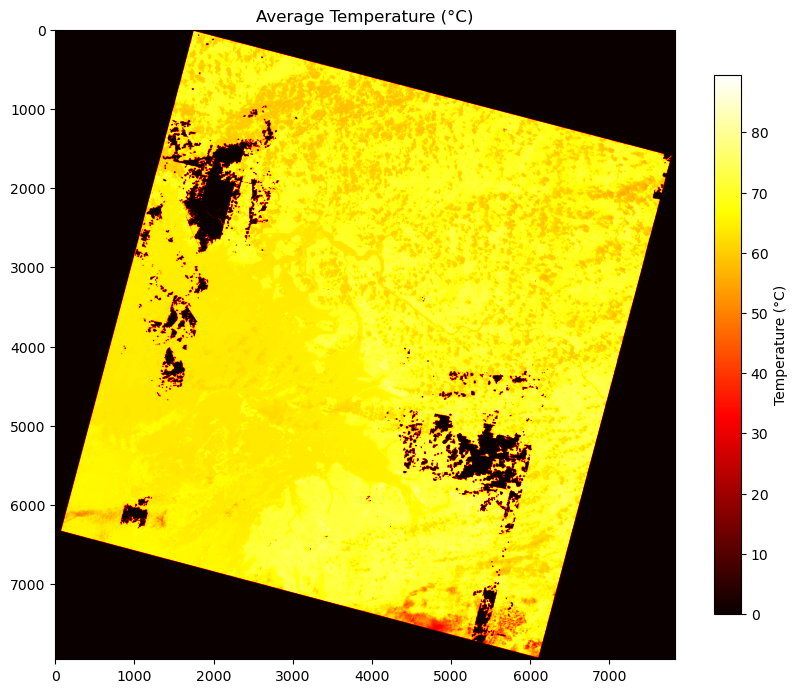

In [278]:
# 데이터 배열 BAND10_ASBT_C에서 최소값과 최대값 계산
min_value = np.min(BAND10_celsius)
max_value = np.max(BAND10_celsius)

# 컬러바를 표시하기 위해 Matplotlib 그래프 생성
plt.figure(figsize=(10, 10))
plt.title("Average Temperature (°C)")
# 데이터 플로팅
image = plt.imshow(BAND10_celsius, cmap='hot', origin='upper', vmin=min_value, vmax=max_value)

# 컬러바 추가
colorbar = plt.colorbar(image, shrink=0.7, label="Temperature (°C)")

In [117]:
import folium
from rasterio.plot import show
import matplotlib.pyplot as plt
from folium import plugins
from matplotlib.colors import ListedColormap

# Folium 맵 생성
m = folium.Map(location=[37.37105949652944, 126.88130200939035], zoom_start=10)  # 지도의 중심 좌표와 줌 레벨 설정


# bounds를 오른쪽으로 미세 조정
# 이미지 배열
image_array = xml_df['tem_array'].tolist()[0]

# ImageOverlay 추가
folium.raster_layers.ImageOverlay(
    image=image_array,
    bounds=polygon_coordinates,  # 폴리곤의 좌표를 bounds로 설정
    opacity=0.9,
    interactive=True,
).add_to(m)

# Folium 맵 표시
m

In [149]:
b4_path = "dataset/Landsat8/LC08_L2SP_116034_20210602_20210608_02_T1/LC08_L2SP_116034_20210602_20210608_02_T1_SR_B4.TIF"
b5_path = "dataset/Landsat8/LC08_L2SP_116034_20210602_20210608_02_T1/LC08_L2SP_116034_20210602_20210608_02_T1_SR_B5.TIF"
# GeoTIFF 파일 열기
b4 = rasterio.open(b4_path).read(1).astype(float)
b5 = rasterio.open(b5_path).read(1).astype(float)

In [ ]:
src_qa = "dataset/Landsat8/LC08_L2SP_116034_20210602_20210608_02_T1/LC08_L2SP_116034_20210602_20210608_02_T1_ST_QA.TIF"

with rasterio.open(src_qa) as qa_raster:
        # Update the raster profile to use 0 as 'nodata'
        profile = qa_raster.profile
        profile.update(nodata=0)
        show(qa_raster.read(1))
        write_cloud_mask(qa_raster.read(1), profile, os.path.join(dst_folder, 'cloudmask.TIF'))

In [ ]:
# 배열을 flatten하여 1차원 배열로 변환
flattened_array = xml_df['tem_array'].tolist()[0].flatten()

# 히스토그램 생성
plt.hist(flattened_array, bins=np.arange(1, flattened_array.max()+2), align='left', rwidth=0.8)

# 그래프 제목과 레이블 추가
plt.title('Frequency Distribution of Elements')
plt.xlabel('Element Value')
plt.ylabel('Frequency')

# y축 눈금을 int 형식으로 설정
plt.yticks(np.arange(0, int(max(plt.hist(flattened_array)[0]))+1, 1))

# 그래프 표시
plt.show()